<a href="https://colab.research.google.com/github/hugomtr/CS50X-AI/blob/master/3_b_Visualizing_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-b: Visualizing Neural Networks

#### To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.



In [ ]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

## Functions and useful variables

In [ ]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Scale(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else transforms.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().detach().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

## Load the model

For this TME, we will use the Squeezenet model which is a light model pre-trained on ImageNet. This model will be frozen: the goal is not to modify or train the weights but to study them.

In [ ]:
# Load the model
model = torchvision.models.squeezenet1_1(pretrained=True)

# Model in test mode
model.eval()

# Freeze the weights
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

## Load example images

This will fill the variables `X, y, class_names` with 25 examples from the validation set of ImageNet. `X` containes the images, `y` the class index of each image, and `class_names` a dictionary giving the class name from its index.

In [ ]:
# Download data
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp9/imagenet_val_25.npz

--2022-01-14 17:41:35--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp9/imagenet_val_25.npz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp9/imagenet_val_25.npz [following]
--2022-01-14 17:41:35--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp9/imagenet_val_25.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [application/octet-stream]
Saving to: ‘imagenet_val_25.npz’

imagenet_val_25.npz 100%[===================>]   3.76M  --.-KB/s    in 0.07s   

2022-01-14 17:41:36 

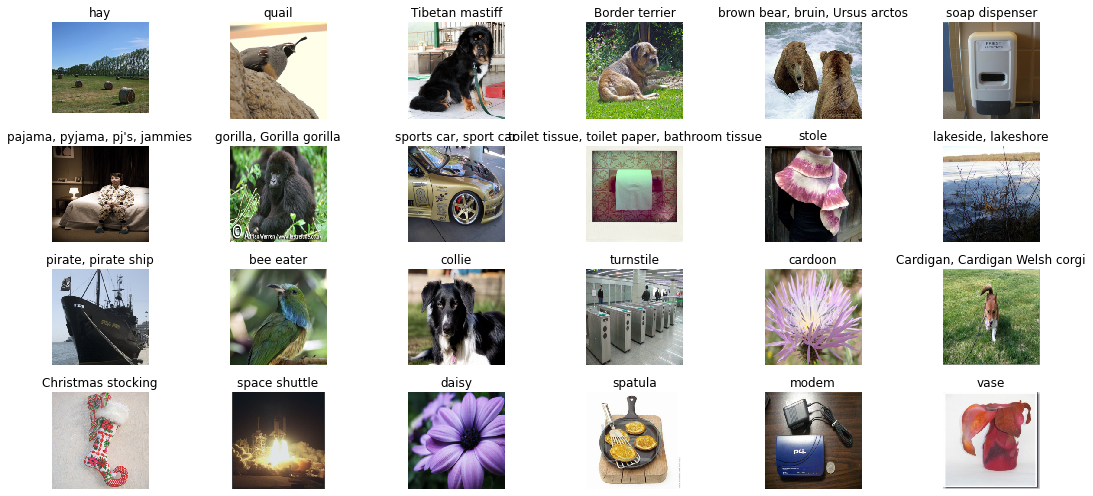

In [ ]:
f = np.load("imagenet_val_25.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps

Calculate the saliency map for 5 examples out of the 25 loaded ones following the instructions of the TP guide.

**Hint :** To choose 1 particular value in each row of a matrix, you can do this:

```python
x = torch.Tensor([[0.1, 0.0, 0.5, 0.1, 0.1],
                  [0.0, 0.1, 0.0, 0.6, 0.2],
                  [0.7, 0.1, 0.1, 0.3, 0.0]])
x[np.arange(3), [2, 3, 0]]
# 0.5000
# 0.6000
# 0.7000
#[torch.FloatTensor of size 3]
```

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.
    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # activate gradients on X
    X.requires_grad = True
    saliency = None
    ##############################################################################
    # Perform a forward and backward pass through the model to compute the       #
    # gradient of the correct class score with respect to each input image.      #
    # You first want to extract the logits for the correct scores (not the loss) #
    # and then compute the gradients with a backward pass.                       #
    ##############################################################################
    preds = model(X) # (N,1000)
    # Get the right classes' scores for all images in the batch
    interesting_logits = preds[torch.arange(len(y)),y] 
    assert interesting_logits.shape == y.shape
    # interesting_logits.backward(torch.ones(len(y))) # ligne équivalente
    interesting_logits.sum().backward()     
    # =/= wrt classic backwards : ONLY THE CORRECT CLASS SCORE

    # Get the maximal responses in each image's gradient
    saliency = torch.max(torch.abs(X.grad),dim=1)[0]
    pred = [class_names[torch.argmax(preds,dim=1)[i].item()] for i in range(preds.shape[0])]
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency, pred

def show_saliency_maps(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    # Compute saliency maps for images in X
    saliency,pred = compute_saliency_maps(X_tensor, y_tensor, model)
    # print("here", saliency.shape, X_tensor.shape)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i+1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(pred[i].split(',')[0]+'\n'+ r"$\bf{"+class_names[y[i]].split(',')[0]+"}$")
        plt.subplot(2, N, N+i+1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

Test your code with the following function:

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


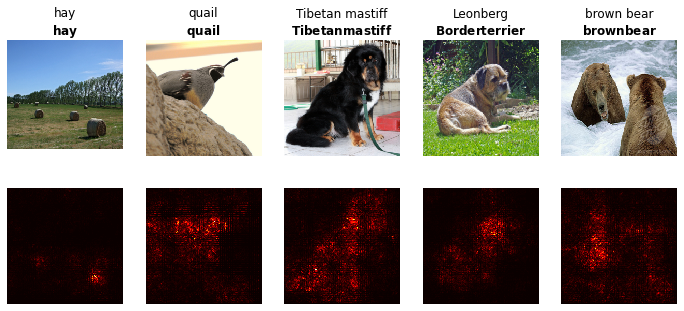

In [ ]:
for i in range(1): # range(5) pour tester toutes les images
    show_saliency_maps(X[5*0:5*0+5], y[5*0:5*0+5], model)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


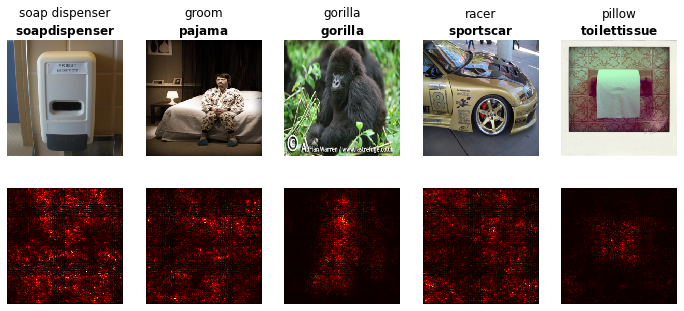

In [ ]:
show_saliency_maps(X[5*1:5*1+5], y[5*1:5*1+5], model)

In [ ]:
# Loading the model
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()
for param in vgg16.parameters():
    param.requires_grad = False
# Showing its structure
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


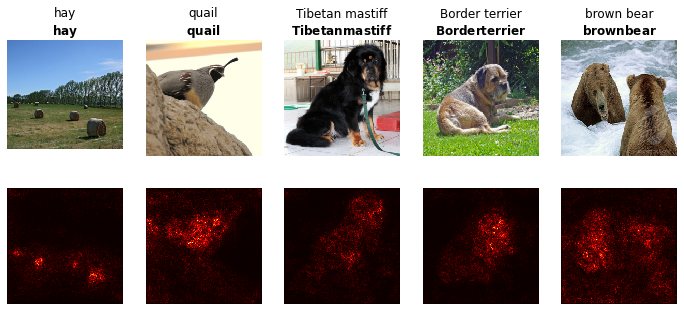

In [ ]:
# Trying with VGG16
for i in range(1): # range(5) pour tester toutes les images
    show_saliency_maps(X[5*0:5*0+5], y[5*0:5*0+5], vgg16)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


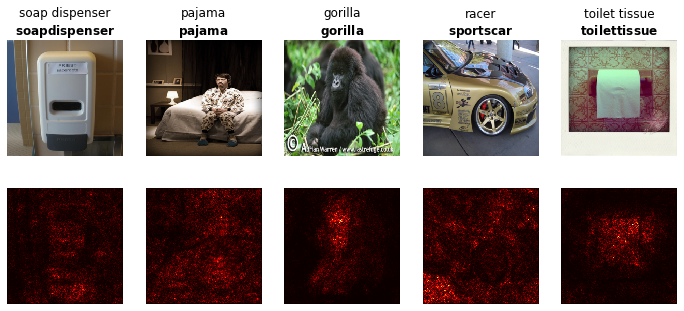

In [ ]:
show_saliency_maps(X[5*1:5*1+5], y[5*1:5*1+5], vgg16)

# Adversarial Examples (Fooling Images)

Write the code to calculate an image such that it will be classified in a `target_y` different from the real class (by modifying the image and not the network parameters). See the TP guide for instructions.

**The first two blocks will allow you to perform tests in an interactive way** to write and test your code. Once your code seems to work, complete the function in the 3rd block and test on various images in the 4th block.

In [ ]:
# Initialize tests
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[0])))
target_y = class_names_to_id['stingray']  # Desired class
X_fooling = X_tensor.clone()
X_fooling.requires_grad = True
learning_rate = 1

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


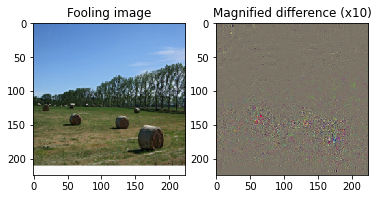

In [ ]:
logits = model(X_fooling)[0] # [0] to get the Tensor associated to the only input image in the "batch"
while logits.argmax().item() != target_y:
  # Keep on trying to fool the model
  logits = model(X_fooling)[0]
  logit = logits[target_y]
  logit.backward() # Backpropagating only the target class' score
  X_fooling.data += X_fooling.grad / X_fooling.grad.norm() * 0.1 # Modifying the input accordingly w/ a learning rate
  X_fooling.grad.zero_()

plt.subplot(1,2,1)
plt.imshow(np.asarray(deprocess(X_fooling.clone())).astype(np.uint8))
plt.title("Fooling image")
plt.subplot(1,2,2)
plt.imshow(np.asarray(deprocess(10*(X_fooling - X_tensor), should_rescale=False)))
plt.title("Magnified difference (x10)")
plt.show()

In [ ]:
# Chargement du modèle
squeeze = torchvision.models.squeezenet1_1(pretrained=True)
squeeze.eval()
for param in squeeze.parameters():
    param.requires_grad = False
squeeze

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
def make_fooling_image(X, target_y, model, learning_rate):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.
    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN
    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, enable gradients.
    X_fooling = X.clone()
    X_fooling.requires_grad = True
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * grad / ||grad||_2                                   #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    # HINT: Remember to reset gradients at each step                             #
    # HINT: update shouldn't be tracked by the autograd (see for example         #
    # https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_autograd.html#sphx-glr-beginner-examples-autograd-two-layer-net-autograd-py #
    ##############################################################################
    for i in range(100):
      logits = model(X_fooling)[0]
      if logits.argmax().item() == target_y:
        break
      logit = logits[target_y]
      logit.backward()
      # equiv X_fooling.data += X_fooling.grad / X_fooling.grad.norm() * 0.1
      with torch.no_grad():
        X_fooling += X_fooling.grad / X_fooling.grad.norm() * learning_rate
      X_fooling.grad.zero_()
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling, i

In [ ]:
def showFooling(idx,target_y,model,X=X,lr=1):
  # Indice de l'image à modifier et de la classe cible en argument
  # Préparation du tenseur X et sa version "fooling"
  X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
  X_fooling, i = make_fooling_image(X_tensor[idx:idx+1], target_y, model,lr)
  # Vérification de la classe prédite
  scores = model(X_fooling)
  # Affichage
  X_fooling_np = deprocess(X_fooling.clone())
  X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)
  plt.subplot(1, 4, 1)
  plt.imshow(X[idx])
  plt.title(class_names[y[idx]])
  plt.axis('off')
  plt.subplot(1, 4, 2)
  plt.imshow(X_fooling_np)
  plt.title(class_names[model(X_fooling)[0].argmax().item()]) # THIS WAS CHANGED - was class_names[target_y]
  plt.axis('off')
  plt.subplot(1, 4, 3)
  X_pre = preprocess(Image.fromarray(X[idx]))
  diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
  plt.imshow(diff)
  plt.title('Difference ')
  plt.axis('off')
  plt.subplot(1, 4, 4)
  diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
  plt.imshow(diff)
  plt.title('Magnified difference (10x)')
  plt.axis('off')
  plt.gcf().set_size_inches(12, 5)
  plt.show()
  
  # We chose to move the assertion to here,
  # to be able to visualise the result even though it didn't work in 100 its.
  # See the change in the image titles above
  assert target_y == scores.data.max(1)[1][0], 'The model is not fooled!'

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


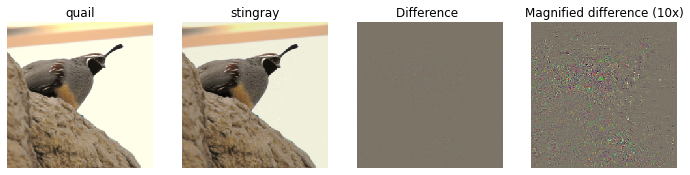

In [ ]:
  showFooling(1,class_names_to_id['stingray'],squeeze)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


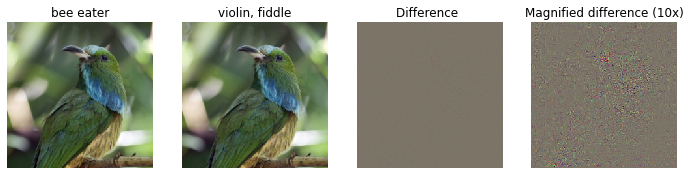

In [ ]:
showFooling(13,class_names_to_id['violin, fiddle'],squeeze)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


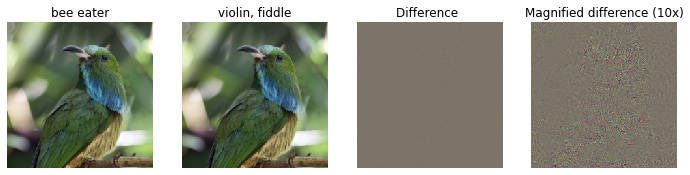

In [ ]:
showFooling(13,class_names_to_id['violin, fiddle'],vgg16)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


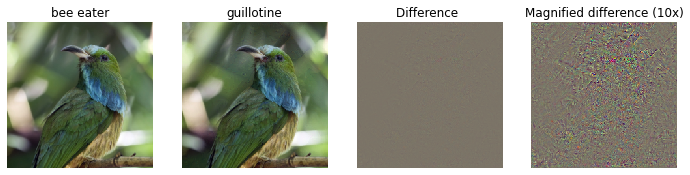

In [ ]:
showFooling(13,class_names_to_id['guillotine'],vgg16)


In [ ]:
# Index of the image to modify and the target class
idx = 1
target_y = class_names_to_id['stingray']

# Preparation of tensor X and it's "fooling" version
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

# Check the predicted class
scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0], 'The model is not fooled!'

# Display
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


TypeError: ignored

### Bonus : test with different input images and different target classes.

# Class visualization

Write the code which generates an image maximizing the score of a class, subject to a certain number of regularizations. See the TP guide for details.


In [ ]:
def create_class_visualization(target_y, model, dtype, init_img=None, l2_reg=1e-3, learning_rate=5,
                               num_iterations=200, blur_every=10, max_jitter=16, show_every=25):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - init_img: Initial image to use (if None, will be random)
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)

    # Randomly initialize the image as a PyTorch Tensor
    if init_img is None:
        img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).detach()
    else:
        img = init_img.clone().mul_(1.0).type(dtype).detach()
    img.requires_grad = True

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img = (jitter(img, ox, oy)).clone().detach()
        img.requires_grad = True

        ########################################################################
        # - TODO: Use the model to compute the gradient of the score for the   #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # - Be very careful about the signs of elements in your code.          #
        # - Advice: compute backward on the raw logits (not the loss), it      #
        # works better                                                         #
        ########################################################################
        pass
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

Test with various classes and starting from random noise:

In [ ]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
# target_y = 113 # Snail
# target_y = np.random.randint(1000) # Classe aléatoire
out = create_class_visualization(target_y, model, dtype, show_every=25, num_iterations=200)

Test by starting from an image from ImageNet:

In [ ]:
# Initialize test
img_ind = 0

target_y = 113 # snail
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(target_y, model, dtype, init_img=X_tensor, show_every=25, num_iterations=200)